## MVP for GrowBikeNet implementation

In [38]:
# import libraries
import os

import osmnx as ox
import pandas as pd
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import LineString, MultiLineString

from itertools import combinations

# import functions
from src.functions import *

# import visualization
from src.visualizations import make_video

### User Input:

In [2]:
city_name = 'Oelde'
seed_point_spacing = 3000 # distance between seed points, in meters
orig_crs = '4326'
proj_crs = '3857'
seed_point_delta = 500 # maximal distance between seed point and actual point in OSM data, in meters

### Data from OSM

In [3]:
# fetch street network data from osmnx
g = ox.graph_from_place(
    city_name, network_type='all'
)
g_undir = g.to_undirected().copy() # convert to undirected (dropping OSMnx keys!)

# # plausibility check
# ox.plot_graph(g, figsize=(10, 10))

### Street network data

In [4]:
# export osmnx data to gdfs
nodes, edges = ox.graph_to_gdfs(
    g_undir,
    nodes=True,
    edges=True,
    node_geometry=True,
    fill_edge_geometry=True
)

# save "original" graph data (in orig_crs)
nodes.to_file("nodes.gpkg", driver='GPKG')
edges.to_file("edges.gpkg", driver='GPKG')

# replace after dropping edges with key = 1
edges = edges.loc[:,:,0].copy()
# this also means we are dropping the "key" level from edge index (u,v,key becomes: u,v)

# project geometries of nodes and edges
edges = edges.to_crs(proj_crs)
nodes = nodes.to_crs(proj_crs)

# add osm ID as column to node gdf
nodes["osmid"] = nodes.index

### Seed points

In [5]:
seed_points = get_seed_points(edges, proj_crs, seed_point_spacing)
# # plausibility check 
# seed_points.plot() 

### Snap Seed points to OSM nodes

In [6]:
# query nearest OSM nodes with sindex
q = nodes.sindex.nearest(seed_points.geometry)
seed_points["osmid"] = None
seed_points.iloc[q[0], -1] = list(nodes.iloc[q[1]]["osmid"])

# create a subset of OSM nodes - only those that seed points are snapped to
nodes_subset = nodes.loc[
    nodes.osmid.isin(seed_points.osmid)
].copy().reset_index(drop=True)

# merge seed points gdf (gives us the generated seed point location, "geometry_generated")
# with nodes subset gdf (gives us all other columns)
# (we need the geometry_generated column only for filtering by distance)
seed_points_snapped = pd.merge(
    left=seed_points, 
    right=nodes_subset,
    how="inner",
    on="osmid",
    suffixes=["_generated", "_osm"]
)

# define our boolean distance_condition filter:
# snapped seed points must be not more than seed_point_delta away
# from their OSM nodes
distance_condition = seed_points_snapped.geometry_generated.distance(
    seed_points_snapped.geometry_osm) <= seed_point_delta

# filter seed_points_snapped df by distance condition
seed_points_snapped = seed_points_snapped[distance_condition].reset_index(drop=True)
seed_points_snapped = seed_points_snapped[
    ["osmid", "geometry_osm"]
] # drop not-needed columns
# rename geometry column
seed_points_snapped = seed_points_snapped.rename(
    columns={"geometry_osm":"geometry"})

# set "geometry" as geometry column
seed_points_snapped = seed_points_snapped.set_geometry("geometry")
# set osmid as *index* of this df
seed_points_snapped = seed_points_snapped.set_index("osmid")
seed_points_snapped["osmid"] = seed_points_snapped.index

<Axes: >

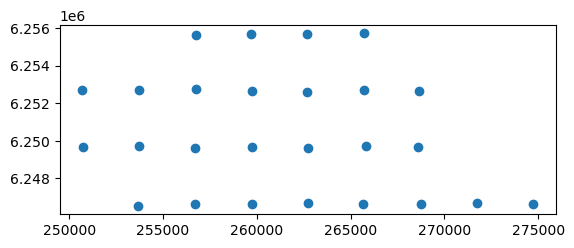

In [7]:
# plausibility check
seed_points_snapped.plot()

### Greedy triangulation

In [8]:
# step 1: get list of potential edges, ordered by length
pairs = []
potential_edges = []
distances = []

for pair in combinations(seed_points_snapped["osmid"], 2):

    edge = LineString(seed_points_snapped.loc[list(pair)].geometry)

    pairs.append(pair)
    potential_edges.append(edge)
    distances.append(edge.length)

df = pd.DataFrame(
    {
        "pair": pairs,
        "potential_edge": potential_edges,
        "dist": distances
    }
)

df = df.sort_values(by="dist", ascending=True).reset_index(drop=True)
df = df[df["dist"]>0].reset_index(drop=True) # only keep distances > 0
df.head(10)

,pair,potential_edge,dist
0,"(1334006463, 11949688144)",LINESTRING (265807.43333788175 6249692.6470769...,2786.099897
1,"(280212178, 25245056)",LINESTRING (265733.1387097263 6252671.36252459...,2907.481768
2,"(12170470372, 8532201322)",LINESTRING (256771.38536731197 6252734.5887990...,2916.416509
3,"(11037159986, 11107730995)",LINESTRING (262751.5797322174 6246689.20560187...,2925.244501
4,"(8532201322, 11022907600)",LINESTRING (256762.15698152527 6255650.9907076...,2928.294842
5,"(11037159986, 169307545)",LINESTRING (262751.5797322174 6246689.20560187...,2932.531509
6,"(12170470372, 11027642349)",LINESTRING (256771.38536731197 6252734.5887990...,2961.519813
7,"(11027642349, 2688735484)",LINESTRING (259731.8047735192 6252653.86368727...,2967.779804
8,"(1334006463, 280212178)",LINESTRING (265807.43333788175 6249692.6470769...,2979.641826
9,"(2503984177, 470171)",LINESTRING (253734.71210991137 6249686.8782091...,2983.226678


In [10]:
# step 2: iterate through all potential edges;
# if they dont intersect with existing edges add to multilinestring

current_edges = MultiLineString()
edge_list = []

for i, row in df.iterrows():
    new_edge = row.potential_edge
    pair = row.pair
    if not intersects_properly(current_edges, new_edge):
        current_edges = MultiLineString([linestring for linestring in current_edges.geoms] + [new_edge])
        edge_list.append(pair)

In [11]:
# step 3: make graph object from edge list
A = nx.Graph()
A.add_nodes_from(seed_points_snapped.index)
A.add_edges_from(edge_list)

In [12]:
# step 4: add betweenness attributes to edges
bc_values = nx.edge_betweenness_centrality(A, normalized=True)
nx.set_edge_attributes(A, bc_values, name='betweenness_centrality')

In [13]:
# # commenting this out for now since we don't have ranking by closeness implemented yet
# # step 5: add closeness attributes to nodes
# closeness = nx.closeness_centrality(A)
# nx.set_node_attributes(A, closeness, name='closeness_centrality')

In [14]:
# step 6: export attributes to gdfs

# as above - commenting out because closeness not yet implemented
# a_nodes = pd.DataFrame.from_dict(
#     nx.get_node_attributes(
#         G=A, 
#         name="closeness_centrality"), 
#     orient="index",
#     columns = ["closeness_centrality"]
# )
# a_nodes["node"] = a_nodes.index
# a_nodes.reset_index(drop=True, inplace=True)

a_edges = pd.DataFrame.from_dict(
    nx.get_edge_attributes(
        G=A,
        name="betweenness_centrality",
    ),
    orient="index",
    columns=["betweenness_centrality"]
)
a_edges["node_tuple"] = a_edges.index
a_edges["source"] = [t[0] for t in a_edges.node_tuple]
a_edges["target"] = [t[1] for t in a_edges.node_tuple]
a_edges.drop(columns=["node_tuple"], inplace=True)

# step 7: rank by attribute/sorting metric
a_edges = a_edges.sort_values(by='betweenness_centrality', ascending = False)
a_edges.reset_index(drop=True, inplace=True)
a_edges["rank"] = a_edges.index # ranking is simply the order of appearance in the betweenness ranking
a_edges.head()

,betweenness_centrality,source,target,rank
0,0.083694,8532201322,13485149160,0
1,0.079277,6760443696,9592962428,1
2,0.078765,13485149160,9592962428,2
3,0.062315,6760443696,169307545,3
4,0.056690,6760443696,2503984177,4


In [15]:
# step 8: map each abstract edge to a merged geometry of corresponding osmnx edges (routed on g_undir)

# step 8a: get edge list that we can use to index our edges gdf
paths = []
for _, row in a_edges.iterrows():
    paths.append(
        nx.shortest_path(
            G=g_undir, # !! use undirected graph here
            source=int(row.source),
            target=int(row.target), 
            weight='length')
    )
a_edges["path_nodes"] = paths
a_edges["path_edges"] = a_edges.path_nodes.apply(lambda x: get_correct_edgetuples(edges, x))
# now the column path_edges contains a set of osmnx edges for each row (abstract edge)

# Step 8b: get "routed" geometry (LineString) for each abstract edge (row)

# get geometry by merging all geoms from edge gdf
a_edges["geometry"] = a_edges.path_edges.apply(
    lambda x: edges.loc[x].geometry.union_all()
)
# convert a_edges into a gdf
a_edges = gpd.GeoDataFrame(a_edges, crs = edges.crs, geometry="geometry")
# merge multilinestring into linestring where possible (should be possible everywhere)
a_edges["geometry"] = a_edges.line_merge()

In [16]:
# plausibility check: now a_edges contains all of our results we wanted to get,
# will be saving a_edges to file, then plotting.
a_edges.head()

,betweenness_centrality,source,target,rank,path_nodes,path_edges,geometry
0,0.083694,8532201322,13485149160,0,"[8532201322, 8532201326, 8532201323, 853220131...","[(8532201322, 8532201326), (8532201323, 853220...","LINESTRING (256762.157 6255650.991, 256770.673..."
1,0.079277,6760443696,9592962428,1,"[6760443696, 6760443698, 2303848348, 577346799...","[(6760443696, 6760443698), (2303848348, 676044...","LINESTRING (253687.39 6246533.74, 253711.981 6..."
2,0.078765,13485149160,9592962428,2,"[13485149160, 9386178229, 11078981456, 8168175...","[(9386178229, 13485149160), (9386178229, 11078...","LINESTRING (265698.04 6255716.355, 265709.272 ..."
3,0.062315,6760443696,169307545,3,"[6760443696, 6760443698, 2303848348, 577346799...","[(6760443696, 6760443698), (2303848348, 676044...","LINESTRING (253687.39 6246533.74, 253711.981 6..."
4,0.056690,6760443696,2503984177,4,"[6760443696, 2303848350, 7100192307, 710019230...","[(2303848350, 6760443696), (2303848350, 710019...","LINESTRING (253734.712 6249686.878, 253703.91 ..."


<Axes: >

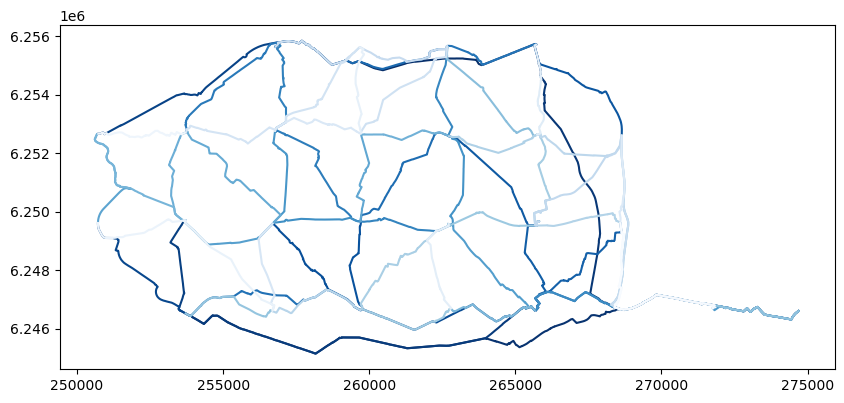

In [17]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
a_edges.plot(ax=ax, column="rank", cmap="Blues_r")
#seed_points_snapped.plot(ax=ax, color="grey")

In [18]:
# Step 9: save to file
a_edges.to_file("a_edges.gpkg", driver="GPKG")

### Visualization

In [19]:
# create directories
os.makedirs("./results/", exist_ok=True)
os.makedirs("./results/plots/", exist_ok=True)
os.makedirs("./results/plots/video/", exist_ok=True)

In [20]:
# read in file to plot
routed_edges_gdf = gpd.read_file("a_edges.gpkg")

In [21]:
# viz/plot settings (move to config file later)

# define color palette (from Michael's project: https://github.com/mszell/bikenwgrowth/blob/main/parameters/parameters.py)
streetcolor = "#999999"
edgecolor = "#0EB6D2"
seedcolor = "#ff7338"

# define linewidths

lws = {
   "street": 0.75,
   "bike": 2
}

In [22]:
for rank in sorted(routed_edges_gdf["rank"].unique()):

    fig, ax = plt.subplots(1,1, figsize=(10,10))

    # first, plot street network as "base line"
    routed_edges_gdf.plot(
        ax=ax,
        color=streetcolor,
        lw=lws["street"],
        zorder=0
    )

    # plot all edges up to current rank

    routed_edges_gdf[routed_edges_gdf["rank"]<=rank].plot(
        ax=ax,
        color=edgecolor,
        lw=lws["bike"],
        zorder=1
    )

    seed_points_snapped.plot(
        ax=ax,
        color=seedcolor,
        zorder=2
    )

    ax.set_axis_off()

    plot_id = "{:03d}".format(rank) # format plot ID with leading zeros
    
    fig.savefig(f"./results/plots/{plot_id}.png", dpi=300)

    plt.close()

In [24]:
make_video(
    img_folder_name="./results/plots/",
    fps = 1
)